In [41]:
#!/usr/bin/env python3
from argparse import ArgumentParser
import numpy as np
import torch
from data import PermutedMNIST
from train import train
from model import MLP
import utils
import random
import matplotlib.pyplot as plt



batch_size = 128
fisher_estimation_sample_size = 2048
weight_decay = 0
cuda=False
task_number = 5





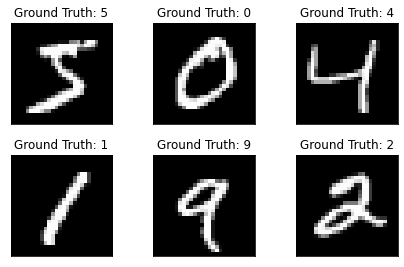

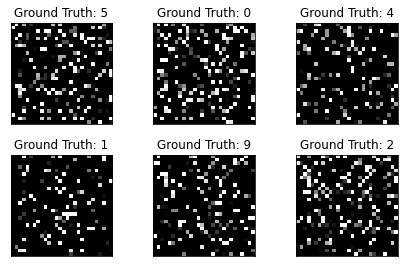

In [2]:
def imshow(img,labels):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(img[i].view(28,28), cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(labels[i]))
        plt.xticks([])
        plt.yticks([])
            
            
def get_permute_mnist(task_number):
   
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(task_number):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train = False, permute_idx= idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist(task_number)

#unpermuted data:
examples_unpermuted = enumerate(train_loader[0])

_, (example_data_unpermuted, example_targets_unpermuted) = next(examples_unpermuted)

imshow(example_data_unpermuted[:6], example_targets_unpermuted[:6])

#permuted data:
examples_permuted = enumerate(train_loader[1])

_, (example_data_permuted, example_targets_permuted) = next(examples_permuted)
imshow(example_data_permuted[:6], example_targets_permuted[:6])

In [3]:
#could also cut last 5 items which are ignored by early stopping
def loss_plot(x):
    num_epochs = 0
    for task in range(1, task_number+1):
        plt.plot(range(num_epochs+1, num_epochs + 1 + len(x[task])), x[task] )
        num_epochs+= len(x[task])
        
def accuracy_plot(x):
    total_epochs = len(x[1])
    for task in range(1, task_number + 1):
        plt.plot(range(total_epochs+1 - len(x[task]), total_epochs+1), x[task] )



In [4]:
def avg_precision_plot(precisions, labels = []): #precisions needs to be in the form of the return value of train
    for num, precision in enumerate(precisions):    
        avg_precisions = []
        total_epochs = task_number*epochs_per_task
        for epoch in range (total_epochs):
            avg_precision = 0
            tasks_considered = epoch // epochs_per_task +1 #gives 1 for first task, 2 for second,...
            for i in range(1,tasks_considered+1): #
                avg_precision += precision[i][epoch - (i-1)*epochs_per_task]
            avg_precision/=tasks_considered
            avg_precisions.append(avg_precision)
        plt.ylim(0.88, 0.94)
        if (len(labels) == len(precisions)):
            plt.plot(range(total_epochs), avg_precisions, label = labels[num])
        else:
            plt.plot(range(total_epochs), avg_precisions)
    plt.legend()
    

In [42]:
#high learning rate, no dropout, no early stopping
hidden_size1=512
hidden_size2 = 256
lamda=400
lr=5.e-2
hidden_dropout_prob=0
input_dropout_prob=0
early_stopping = False
consolidate = False
epochs_per_task =50

In [6]:
# prepare the model.
mlp_no_dropout_no_earlystopping = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the weights.
utils.gaussian_initialize(mlp_no_dropout_no_earlystopping)

# prepare the cuda if needed.
if cuda:
    mlp_no_dropout.cuda()


In [7]:
# run the standard experiment.
(standard_prec_no_dropout_no_earlystopping, 
 standard_total_loss_no_dropout_no_earlystopping,
 standard_ce_loss_no_dropout_no_earlystopping,
 standard_ewc_loss_no_dropout_no_earlystopping) = train(
    mlp_no_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.4371 / ewc: 0.0 / total: 0.4371: : 469it [00:05, 91.38it/s] 
=> task: 1/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3681 / ewc: 0.0 / total: 0.3681: : 469it [00:04, 99.36it/s]   
=> task: 1/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.3295 / ewc: 0.0 / total: 0.3295: : 469it [00:04, 99.29it/s]   
=> task: 1/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2982 / ewc: 0.0 / total: 0.2982: : 469it [00:04, 98.95it/s]   
=> task: 1/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.276 / ewc: 0.0 / total: 0.276: : 469it [00:05, 93.38it/s]     
=> task: 1/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2608 / ewc: 0.0 / total: 0.2608: : 469it [00:05, 88.37it/s]  
=> task: 1/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9792 | lo

=> task: 3/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1521 / ewc: 0.0 / total: 0.1521: : 469it [00:05, 87.80it/s]  
=> task: 3/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1411 / ewc: 0.0 / total: 0.1411: : 469it [00:05, 87.98it/s]  
=> task: 3/5 | epoch: 8/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1334 / ewc: 0.0 / total: 0.1334: : 469it [00:05, 92.03it/s]  
=> task: 3/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1268 / ewc: 0.0 / total: 0.1268: : 469it [00:05, 89.27it/s]  
=> task: 3/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1192 / ewc: 0.0 / total: 0.1192: : 469it [00:05, 88.72it/s]  
=> task: 3/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1144 / ewc: 0.0 / total: 0.1144: : 469it [00:05, 88.81it/s]   
=> task: 3/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9896 | l

=> task: 5/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1325 / ewc: 0.0 / total: 0.1325: : 469it [00:05, 87.38it/s]   
=> task: 5/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1259 / ewc: 0.0 / total: 0.1259: : 469it [00:05, 86.23it/s]   
=> task: 5/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1182 / ewc: 0.0 / total: 0.1182: : 469it [00:05, 87.55it/s]   
=> task: 5/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1101 / ewc: 0.0 / total: 0.1101: : 469it [00:05, 88.01it/s]   
=> task: 5/5 | epoch: 14/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.09783 / ewc: 0.0 / total: 0.09783: : 469it [00:05, 88.94it/s] 
=> task: 5/5 | epoch: 15/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.0871 / ewc: 0.0 / total: 0.0871: : 469it [00:05, 88.29it/s]   
=> task: 5/5 | epoch: 16/50 | progress: [60032/60000] (100%) | prec: 0

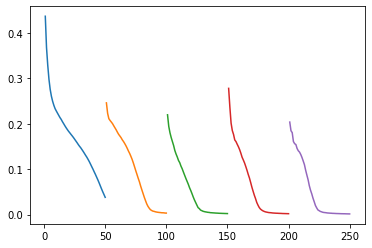

In [8]:
loss_plot(standard_total_loss_no_dropout_no_earlystopping)

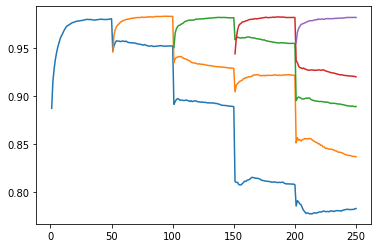

In [9]:
accuracy_plot(standard_prec_no_dropout_no_earlystopping)

In [43]:
mlp_consolidation_no_dropout_no_earlystopping = MLP( 28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_no_dropout_no_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_no_dropout_no_earlystopping, 
 ewc_total_loss_no_dropout_no_earlystopping, 
 ewc_ce_loss_no_dropout_no_earlystopping, 
 ewc_ewc_loss_no_dropout_no_earlystopping) = train(
    mlp_consolidation_no_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.875 | loss => ce: 0.4401 / ewc: 0.0 / total: 0.4401: : 469it [00:05, 81.21it/s]  
=> task: 1/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.3587 / ewc: 0.0 / total: 0.3587: : 469it [00:05, 85.85it/s]   
=> task: 1/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3187 / ewc: 0.0 / total: 0.3187: : 469it [00:05, 86.03it/s]   
=> task: 1/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2913 / ewc: 0.0 / total: 0.2913: : 469it [00:05, 86.36it/s]  
=> task: 1/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.272 / ewc: 0.0 / total: 0.272: : 469it [00:05, 86.51it/s]     
=> task: 1/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.257 / ewc: 0.0 / total: 0.257: : 469it [00:05, 86.37it/s]     
=> task: 1/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9792 | lo

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2344 / ewc: 0.02135 / total: 0.2558: : 469it [00:08, 55.99it/s] 
=> task: 2/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2081 / ewc: 0.0193 / total: 0.2274: : 469it [00:07, 63.64it/s]  
=> task: 2/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1958 / ewc: 0.01781 / total: 0.2136: : 469it [00:07, 60.91it/s] 
=> task: 2/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1833 / ewc: 0.01677 / total: 0.2001: : 469it [00:07, 61.90it/s] 
=> task: 2/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1749 / ewc: 0.01592 / total: 0.1908: : 469it [00:07, 62.44it/s] 
=> task: 2/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1684 / ewc: 0.01524 / total: 0.1836: : 469it [00:07, 61.90it/s] 
=> task: 2/5 | epoch: 7/50 | progress: [60032/60000] (100%) | pr

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2662 / ewc: 0.02191 / total: 0.2881: : 469it [00:08, 56.37it/s] 
=> task: 3/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2282 / ewc: 0.01793 / total: 0.2462: : 469it [00:07, 61.46it/s]  
=> task: 3/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2035 / ewc: 0.01606 / total: 0.2195: : 469it [00:07, 61.66it/s] 
=> task: 3/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1899 / ewc: 0.01489 / total: 0.2047: : 469it [00:07, 61.68it/s] 
=> task: 3/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.18 / ewc: 0.01403 / total: 0.194: : 469it [00:07, 61.39it/s]    
=> task: 3/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1715 / ewc: 0.01337 / total: 0.1849: : 469it [00:07, 61.78it/s] 
=> task: 3/5 | epoch: 7/50 | progress: [60032/60000] (100%) | p

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2422 / ewc: 0.01958 / total: 0.2618: : 469it [00:08, 55.64it/s] 
=> task: 4/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.216 / ewc: 0.01534 / total: 0.2314: : 469it [00:07, 59.70it/s]  
=> task: 4/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2014 / ewc: 0.01336 / total: 0.2147: : 469it [00:07, 60.42it/s] 
=> task: 4/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1937 / ewc: 0.0121 / total: 0.2058: : 469it [00:07, 60.83it/s]  
=> task: 4/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1874 / ewc: 0.01124 / total: 0.1987: : 469it [00:07, 60.51it/s] 
=> task: 4/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1848 / ewc: 0.01056 / total: 0.1954: : 469it [00:07, 60.42it/s] 
=> task: 4/5 | epoch: 7/50 | progress: [60032/60000] (100%) | pr

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2692 / ewc: 0.01721 / total: 0.2865: : 469it [00:08, 56.29it/s] 
=> task: 5/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2275 / ewc: 0.01437 / total: 0.2418: : 469it [00:07, 62.85it/s] 
=> task: 5/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2129 / ewc: 0.01289 / total: 0.2258: : 469it [00:07, 61.73it/s] 
=> task: 5/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1985 / ewc: 0.01193 / total: 0.2104: : 469it [00:07, 61.54it/s] 
=> task: 5/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1876 / ewc: 0.01123 / total: 0.1988: : 469it [00:07, 61.74it/s] 
=> task: 5/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1777 / ewc: 0.01067 / total: 0.1884: : 469it [00:07, 61.17it/s] 
=> task: 5/5 | epoch: 7/50 | progress: [60032/60000] (100%) | pr

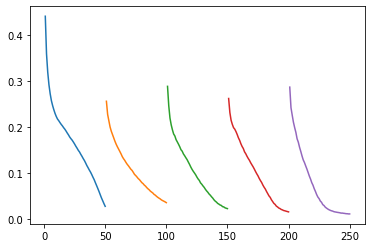

In [44]:
loss_plot(ewc_total_loss_no_dropout_no_earlystopping)

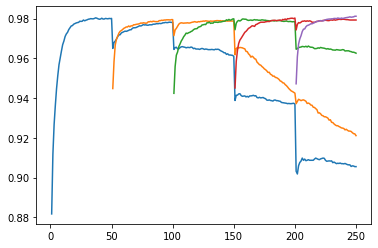

In [45]:
accuracy_plot(ewc_prec_no_dropout_no_earlystopping)

In [46]:
#high learning rate, dropout, no early stopping
hidden_dropout_prob = 0.5
input_dropout_prob = 0.2

In [47]:
# prepare the model.
mlp_dropout_no_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

# initialize the weights.
utils.gaussian_initialize(mlp_dropout_no_earlystopping)

# run the standard experiment.
consolidate = False
(standard_prec_dropout_no_earlystopping,
 standard_total_loss_dropout_no_earlystopping,
 standard_ce_loss_dropout_no_earlystopping,
 standard_ewc_loss_dropout_no_earlystopping) = train(
    mlp_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.8542 | loss => ce: 0.5478 / ewc: 0.0 / total: 0.5478: : 469it [00:05, 79.21it/s]
=> task: 1/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.8854 | loss => ce: 0.4549 / ewc: 0.0 / total: 0.4549: : 469it [00:05, 82.70it/s] 
=> task: 1/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.3518 / ewc: 0.0 / total: 0.3518: : 469it [00:06, 77.92it/s]  
=> task: 1/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.3003 / ewc: 0.0 / total: 0.3003: : 469it [00:06, 76.68it/s]  
=> task: 1/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2676 / ewc: 0.0 / total: 0.2676: : 469it [00:05, 78.58it/s] 
=> task: 1/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2793 / ewc: 0.0 / total: 0.2793: : 469it [00:06, 77.15it/s]  
=> task: 1/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => c

=> task: 2/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2285 / ewc: 0.0 / total: 0.2285: : 469it [00:06, 77.33it/s]  
=> task: 2/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1825 / ewc: 0.0 / total: 0.1825: : 469it [00:05, 80.38it/s] 
=> task: 2/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1549 / ewc: 0.0 / total: 0.1549: : 469it [00:06, 77.27it/s] 
=> task: 2/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2153 / ewc: 0.0 / total: 0.2153: : 469it [00:05, 83.13it/s] 
=> task: 2/5 | epoch: 8/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2315 / ewc: 0.0 / total: 0.2315: : 469it [00:05, 79.09it/s] 
=> task: 2/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2285 / ewc: 0.0 / total: 0.2285: : 469it [00:05, 81.30it/s] 
=> task: 2/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => c

=> task: 3/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2184 / ewc: 0.0 / total: 0.2184: : 469it [00:05, 87.03it/s]   
=> task: 3/5 | epoch: 8/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1488 / ewc: 0.0 / total: 0.1488: : 469it [00:05, 80.46it/s]  
=> task: 3/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.2155 / ewc: 0.0 / total: 0.2155: : 469it [00:05, 78.27it/s]  
=> task: 3/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.182 / ewc: 0.0 / total: 0.182: : 469it [00:05, 83.44it/s]    
=> task: 3/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.167 / ewc: 0.0 / total: 0.167: : 469it [00:05, 91.39it/s]    
=> task: 3/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1934 / ewc: 0.0 / total: 0.1934: : 469it [00:05, 82.22it/s] 
=> task: 3/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9792 | l

=> task: 4/5 | epoch: 9/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1608 / ewc: 0.0 / total: 0.1608: : 469it [00:05, 83.50it/s] 
=> task: 4/5 | epoch: 10/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1939 / ewc: 0.0 / total: 0.1939: : 469it [00:05, 84.20it/s] 
=> task: 4/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1046 / ewc: 0.0 / total: 0.1046: : 469it [00:05, 84.68it/s] 
=> task: 4/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2194 / ewc: 0.0 / total: 0.2194: : 469it [00:05, 85.06it/s] 
=> task: 4/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1895 / ewc: 0.0 / total: 0.1895: : 469it [00:05, 85.01it/s]  
=> task: 4/5 | epoch: 14/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1631 / ewc: 0.0 / total: 0.1631: : 469it [00:05, 84.74it/s] 
=> task: 4/5 | epoch: 15/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss

=> task: 5/5 | epoch: 11/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1554 / ewc: 0.0 / total: 0.1554: : 469it [00:05, 84.23it/s] 
=> task: 5/5 | epoch: 12/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1666 / ewc: 0.0 / total: 0.1666: : 469it [00:05, 84.16it/s] 
=> task: 5/5 | epoch: 13/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1604 / ewc: 0.0 / total: 0.1604: : 469it [00:05, 84.37it/s]  
=> task: 5/5 | epoch: 14/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1722 / ewc: 0.0 / total: 0.1722: : 469it [00:05, 84.56it/s]   
=> task: 5/5 | epoch: 15/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1449 / ewc: 0.0 / total: 0.1449: : 469it [00:05, 84.48it/s] 
=> task: 5/5 | epoch: 16/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1928 / ewc: 0.0 / total: 0.1928: : 469it [00:05, 85.01it/s]  
=> task: 5/5 | epoch: 17/50 | progress: [60032/60000] (100%) | prec: 0.9896 | 

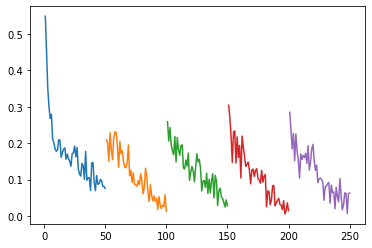

In [48]:
loss_plot(standard_total_loss_dropout_no_earlystopping)

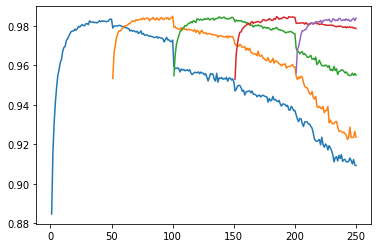

In [49]:
accuracy_plot(standard_prec_dropout_no_earlystopping)

In [50]:
mlp_consolidation_dropout_no_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout_no_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_dropout_no_earlystopping, 
 ewc_total_loss_dropout_no_earlystopping, 
 ewc_ce_loss_dropout_no_earlystopping, 
 ewc_ewc_loss_dropout_no_earlystopping) =train(
    mlp_consolidation_dropout_no_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

=> task: 1/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.8438 | loss => ce: 0.5204 / ewc: 0.0 / total: 0.5204: : 469it [00:05, 82.68it/s]
=> task: 1/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3803 / ewc: 0.0 / total: 0.3803: : 469it [00:05, 83.96it/s] 
=> task: 1/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3263 / ewc: 0.0 / total: 0.3263: : 469it [00:05, 84.12it/s] 
=> task: 1/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3257 / ewc: 0.0 / total: 0.3257: : 469it [00:05, 84.00it/s]  
=> task: 1/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.299 / ewc: 0.0 / total: 0.299: : 469it [00:05, 83.92it/s]    
=> task: 1/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2515 / ewc: 0.0 / total: 0.2515: : 469it [00:05, 83.74it/s]  
=> task: 1/5 | epoch: 7/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => c

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 2/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.275 / ewc: 0.03338 / total: 0.3084: : 469it [00:08, 54.77it/s]  
=> task: 2/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2172 / ewc: 0.02641 / total: 0.2436: : 469it [00:07, 59.26it/s]  
=> task: 2/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1965 / ewc: 0.02274 / total: 0.2193: : 469it [00:07, 58.80it/s] 
=> task: 2/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2032 / ewc: 0.0209 / total: 0.2241: : 469it [00:07, 59.14it/s]  
=> task: 2/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2144 / ewc: 0.01912 / total: 0.2335: : 469it [00:07, 59.08it/s]  
=> task: 2/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1139 / ewc: 0.01811 / total: 0.1321: : 469it [00:07, 59.19it/s] 
=> task: 2/5 | epoch: 7/50 | progress: [60032/60000] (100%) | 

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 3/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.3603 / ewc: 0.03026 / total: 0.3906: : 469it [00:08, 54.18it/s]  
=> task: 3/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2179 / ewc: 0.02359 / total: 0.2415: : 469it [00:07, 61.12it/s] 
=> task: 3/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2195 / ewc: 0.0206 / total: 0.2401: : 469it [00:07, 59.83it/s]   
=> task: 3/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1856 / ewc: 0.0188 / total: 0.2044: : 469it [00:08, 58.57it/s]   
=> task: 3/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2036 / ewc: 0.01753 / total: 0.2211: : 469it [00:07, 58.68it/s] 
=> task: 3/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2189 / ewc: 0.01654 / total: 0.2354: : 469it [00:07, 59.21it/s]  
=> task: 3/5 | epoch: 7/50 | progress: [60032/60000] (100%) 

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 4/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2852 / ewc: 0.02491 / total: 0.3101: : 469it [00:08, 53.29it/s]  
=> task: 4/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1795 / ewc: 0.01956 / total: 0.1991: : 469it [00:08, 57.80it/s] 
=> task: 4/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1988 / ewc: 0.01684 / total: 0.2157: : 469it [00:08, 57.82it/s]  
=> task: 4/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2343 / ewc: 0.01559 / total: 0.2499: : 469it [00:08, 58.11it/s] 
=> task: 4/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.158 / ewc: 0.01446 / total: 0.1725: : 469it [00:08, 57.93it/s]   
=> task: 4/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9896 | loss => ce: 0.1578 / ewc: 0.01356 / total: 0.1714: : 469it [00:08, 58.12it/s]  
=> task: 4/5 | epoch: 7/50 | progress: [60032/60000] (100%) 

=> Estimating diagonals of the fisher information matrix... Done!


=> task: 5/5 | epoch: 1/50 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.2733 / ewc: 0.02511 / total: 0.2984: : 469it [00:08, 54.46it/s]  
=> task: 5/5 | epoch: 2/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2771 / ewc: 0.0195 / total: 0.2966: : 469it [00:07, 60.06it/s]   
=> task: 5/5 | epoch: 3/50 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2431 / ewc: 0.01698 / total: 0.26: : 469it [00:07, 58.87it/s]    
=> task: 5/5 | epoch: 4/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1908 / ewc: 0.01512 / total: 0.2059: : 469it [00:08, 55.48it/s] 
=> task: 5/5 | epoch: 5/50 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.2062 / ewc: 0.01385 / total: 0.22: : 469it [00:08, 57.49it/s]    
=> task: 5/5 | epoch: 6/50 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.2077 / ewc: 0.013 / total: 0.2207: : 469it [00:08, 56.95it/s]    
=> task: 5/5 | epoch: 7/50 | progress: [60032/60000] (100%)

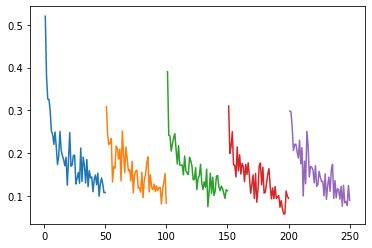

In [51]:
loss_plot(ewc_total_loss_dropout_no_earlystopping)

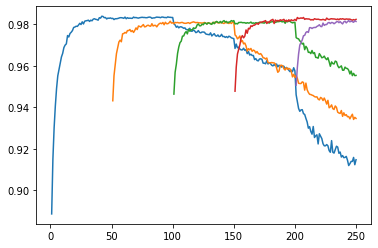

In [52]:
accuracy_plot(ewc_prec_dropout_no_earlystopping)
#model capacity reached after fourth task?

In [ ]:
#dropout and early stopping
early_stopping = True

In [ ]:
mlp_dropout_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_dropout_earlystopping)

# run the standard experiment.
consolidate = False
(standard_prec_dropout_earlystopping, 
 standard_total_loss_dropout_earlystopping,
 standard_ce_loss_dropout_earlystopping,
 standard_ewc_loss_dropout_earlystopping) = train(
    mlp_dropout_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

In [ ]:
loss_plot(standard_total_loss_dropout_earlystopping)

In [ ]:
accuracy_plot(standard_prec_dropout_earlystopping)

In [ ]:
mlp_consolidation_dropout_earlystopping = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_dropout_earlystopping)

# run the standard experiment.
consolidate = True
(ewc_prec_dropout_earlystopping,
 ewc_total_loss_dropout_earlystopping, 
 ewc_ce_loss_dropout_earlystopping,
 ewc_ewc_loss_dropout_earlystopping) =train(
    mlp_consolidation_dropout_earlystopping, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

In [ ]:
loss_plot(ewc_total_loss_dropout_earlystopping)

In [ ]:
accuracy_plot(ewc_prec_dropout_earlystopping)

In [ ]:
#dropout, early stopping, wider layers, higher lambda
lr = 1.e-2
hidden_size1 = 1600
hidden_size2 = 1400
lamda = 2000
task_number = 10
epochs_per_task = 75
train_loader, test_loader = get_permute_mnist(task_number)

In [ ]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_optimised = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_optimised)

# run the standard experiment.
consolidate = False
(standard_prec_optimised,
 standard_total_loss_optimised,
 standard_ce_loss_optimised, 
 standard_ewc_loss_optimised) =train(
    mlp_optimised, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

In [ ]:
loss_plot(standard_total_loss_optimised)

In [ ]:
accuracy_plot(standard_prec_optimised)

In [ ]:
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised, 
 ewc_total_loss_optimised,
 ewc_ce_loss_optimised, 
 ewc_ewc_loss_optimised) =train(
    mlp_consolidation_optimised, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

In [ ]:
loss_plot(ewc_total_loss_optimised)

In [ ]:
accuracy_plot(ewc_prec_optimised)

In [ ]:
#compare performance on first task:
fig = plt.figure(figsize = (20,10))
plt.ylim(0.65,1)
plt.plot(range(1, len(standard_prec_no_dropout_no_earlystopping)+1),
         standard_prec_no_dropout_no_earlystopping, label = 'std_no_drop_no_stop')
plt.plot(range(1, len(ewc_prec_no_dropout_no_earlystopping)+1),
         ewc_prec_no_dropout_no_earlystopping, label = 'ewc_no_drop_no_stop')
plt.plot(range(1, len(standard_prec_dropout_no_earlystopping)+1),
         standard_prec_dropout_no_earlystopping, label = 'std_drop_no_stop')
plt.plot(range(1, len(ewc_prec_dropout_no_earlystopping)+1),
         ewc_prec_dropout_no_earlystopping, label = 'ewc_drop_no_stop')
plt.plot(range(1, len(standard_prec_dropopout_earlystopping)+1),
         standard_prec_dropout_earlystopping, label = 'std_drop_stop')
plt.plot(range(1, len(ewc_prec_dropout_earlystopping)+1),
         ewc_prec_dropout_earlystopping, label = 'ewc_drop_stop')
plt.plot(range(1, len(standard_prec_optimised)+1),
         standard_prec_optimised, label = 'std_opt')
plt.plot(range(1, len(ewc_prec_optimised)+1),
         ewc_prec_optimised, label = 'ewc_opt')
plt.legend()

In [ ]:
lamda = 3000
lr = 1.e-2
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised2 = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised2)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised2, 
 ewc_total_loss_optimised2,
 ewc_ce_loss_optimised2, 
 ewc_ewc_loss_optimised2) =train(
    mlp_consolidation_optimised2, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

In [ ]:
loss_plot(ewc_total_loss_optimised2)

In [ ]:
accuracy_plot(ewc_prec_optimised2)

In [ ]:
lamda = 400
lr = 5.e-2
#does even higher lambda + greater network size help to get better long term results + more epochs
mlp_consolidation_optimised2 = MLP(28*28, 10,
    hidden_size1,
    hidden_size2,
    hidden_dropout_prob,
    input_dropout_prob,
    lamda,
)

utils.gaussian_initialize(mlp_consolidation_optimised2)

# run the standard experiment.
consolidate = True
(ewc_prec_optimised2, 
 ewc_total_loss_optimised2,
 ewc_ce_loss_optimised2, 
 ewc_ewc_loss_optimised2) =train(
    mlp_consolidation_optimised2, train_loader, test_loader,
    epochs_per_task,
    batch_size,
    consolidate,
    fisher_estimation_sample_size,
    lr,
    weight_decay,
    early_stopping,
    cuda
)

In [ ]:
loss_plot(ewc_total_loss_optimised2)

In [ ]:
accuracy_plot(ewc_prec_optimised2)